# Integration Demo

Following is a step-by-step guide comparing the two integration approaches use in the GaussianNEGF package. All steps have been tested on a 20 core system with each step running in seconds except for the final IV step, which can take minutes.

## System Setup

We will be working with an ethane molecule:
<img src="ethane.png" alt="drawing" width="200"/>

**Basis set:** 6-31g(d,p) -  C atoms will have 15 basis functions and H will have 5

**Functional:** B3LYP Hydbrid functional

For this system we will use a diagonal self energy matrix, with $\Gamma_i=0.1$ ($\Sigma_i = -0.05j$). Because this is an energy independent self-energy, we can first test the system using the `NEGF()` type object from the `scf.py` file.

## Energy Independent Approach
To set up the system lets first import the packages and initialize the ethane system:

In [1]:
from gauNEGF.scf import NEGF
from gauNEGF.density import *
from gauNEGF.surfGBethe import *
from matplotlib import pyplot as plt

negf = NEGF(fn='ethane', func='b3lyp', basis='6-31g(d,p)', spin='r')
print(negf.bar.ian)

ERROR:2025-11-04 21:06:50,959:jax._src.xla_bridge:444: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/mmfs1/gscratch/anantram/willll/NEGF/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/mmfs1/gscratch/anantram/willll/NEGF/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 324, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/mmfs1/gscratch/anantram/willll/NEGF/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 281, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE


Calculation started at Tue Nov  4 21:06:50 2025
Filename: ethane
Checking ethane.chk for saved data...
Checkpoint not loaded, running full SCF...
Done!
ORBS:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 4 4
 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7 7 7 7 8 8 8 8 8]
Expecting 18 electrons
Actual:  18.000000000000064 electrons
Charge is: 0
Multiplicity is: 1
Initial SCF energy:  -79.83560168196263
###################################
[6 6 1 1 1 1 1 1]


The gaussian interface `QCBinAr` object is stored in `negf.bar`.

The atomic numbers for each atom are stored in `negf.bar.ian`, which are C, C, H, H, H, H, H, H

Now we can attach the contacts to both carbon atoms:

In [2]:
negf.setSigma([1], [2], -0.05j)

Max imag sigma: 0.050000001


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]))

And set the voltage to zero, setting the Fermi energy to the default value $\left(\frac{E_H + E_L}2\right)$:

In [3]:
negf.setVoltage(0)

Setting initial Fermi energy between HOMO (-9.40 eV) and LUMO (2.91 eV)


Now let's run a quick NEGF-DFT job setting the convergence to $10^{-4}$ and the mixing factor to 0.05:

Entering NEGF-SCF loop at: Tue Nov  4 21:06:56 2025
###################################

Iteration 0:
Bisection fermi search converged to 7.78E-05 in 18 iterations.
Fermi Energy set to -9.31 eV
Applying Damping value= 0.1
Total number of electrons (NEGF): 18.00
MaxDP: 2.74E+00 | RMSDP: 5.04E-01
SCF energy:  -79.80039447139195
Energy difference is: 3.521E-02
Saving density checkpoint...

Iteration 1:
Bisection fermi search converged to 2.79E-04 in 18 iterations.
Fermi Energy set to -9.36 eV
Applying Damping value= 0.1
Total number of electrons (NEGF): 18.00
MaxDP: 2.47E+00 | RMSDP: 4.54E-01
SCF energy:  -79.76872463231852
Energy difference is: 3.167E-02
Saving density checkpoint...

Iteration 2:
Bisection fermi search converged to 7.35E-04 in 18 iterations.
Fermi Energy set to -9.39 eV
Applying Damping value= 0.1
Total number of electrons (NEGF): 18.00
MaxDP: 2.22E+00 | RMSDP: 4.08E-01
SCF energy:  -79.7402564601997
Energy difference is: 2.847E-02
Saving density checkpoint...

Iteration

Text(0, 0.5, 'Total DFT Energy (eV)')

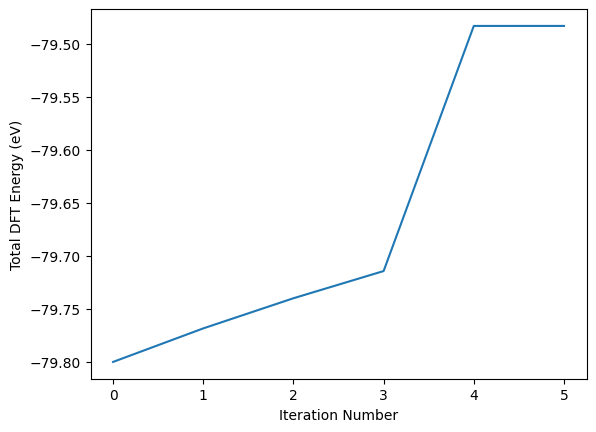

In [4]:
nIter, neList, Elist = negf.SCF(1e-3, 0.1)
# Plot convergence of DFT Energy
plt.plot(nIter, Elist)
plt.xlabel('Iteration Number')
plt.ylabel('Total DFT Energy (eV)')

A quick check of the SCF run can be done by looking at the energy level occupation list printed at the end of the run. As can be seen, the Fermi energy ends up close to the HOMO energy, and the occupation of HOMO energy and below is close to 1.0 whereas all higher energy levels have occupations near 0.0. We can also look at the main diagonal of the density matrix to understand how the atomic orbitals are occupied, multiplying by 2 to account for spin:

Text(0.5, 1.0, '$\\mathbb{Im}\\left[\\rho_{ii}\\right]$')

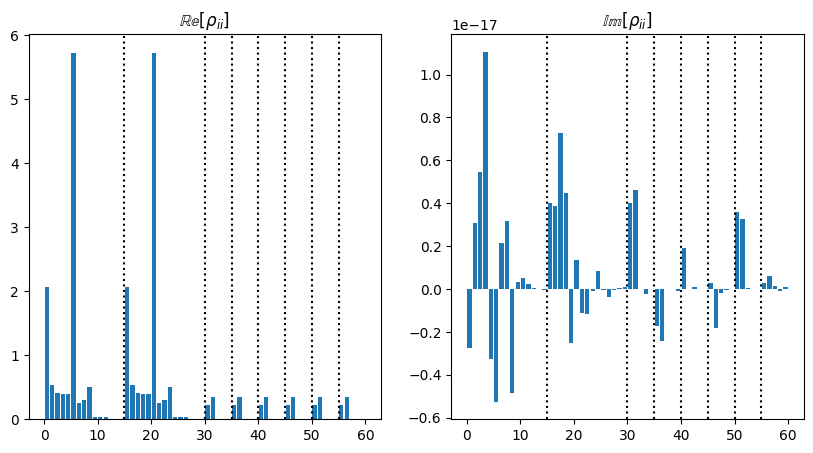

In [5]:
import numpy as np
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
rho = negf.P * 2

# Count number of basis functions per atom:
atlocs = np.cumsum([(negf.bar.ibfatm==i+1).sum() for i in range(negf.bar.natoms-1)])
# Plot dividing lines between each atom
for a in atlocs:
    ax1.axvline(a, color='k', linestyle=':')
    ax2.axvline(a, color='k', linestyle=':')

# Plot real part of the diagonal of the density matrix
ax1.bar(np.arange(len(negf.P))+0.5, np.diag(rho.real))
ax1.set_title(r'$\mathbb{Re}\left[\rho_{ii}\right]$')
# Plot imaginary part of the diagonal of the density matrix
ax2.bar(np.arange(len(negf.P))+0.5, np.diag(rho.imag))
ax2.set_title(r'$\mathbb{Im}\left[\rho_{ii}\right]$')

To integrate the energy independent case, an analytical solution was used by solving the integral equation:

$$
    2 \pi \hat{\rho}_j = \hat{S}^{-\frac12}\left[ \int_{-\infty}^{\infty} f_j(E) \left(\sum_n \frac{|n\rangle}{E - \epsilon_n} \right) \langle n|\bar{\Gamma}_j |n'\rangle \right. \nonumber \\
   \left.  \left(\sum_{n'} \frac{\langle n'|}{E - \epsilon_n^\dagger} \right) dE  \right] \hat{S}^{-\frac12} \ \ \ 
   $$

where

$$
\bar{\Gamma}_j = \hat{S}^{-\frac12}\hat{\Gamma}_j\hat{S}^{-\frac12}\\
\bar{G} = (E \hat{I} - \bar{F})^{-1}\\
\bar{F} =  \hat{S}^{-\frac12}(\hat{F} + \hat{\Sigma}_L + \hat{\Sigma}_R)  \hat{S}^{-\frac12}\\
\bar{F}|n\rangle= \epsilon_n |n\rangle
$$

and $j$ represents the contribution from the jth contact. Note that we will assume that the temperature is zero, so the Fermi function ($f_j(E)$) can be replaced with a finite integral up to $E_{F, j}$. 

In our case, two contacts are applied (the left and right) so

$$
\hat{\rho} = \hat{\rho}_L + \hat{\rho}_R
$$

Since $\bar{\Gamma}_j$ is constant with respect to energy, the solution can be solved without numerical integration, calculating the value of the analytical solution at the integration limits (some $E_{min}$ to represent negative infinity and the fermi energy $E_F$). This matrix math only requires a single diagonalization of $\bar{F}$ to get the values of $\epsilon_n$ and a single matrix exponent to get $\hat{S}^{-\frac12}$. To test this math, we can use numerical integration methods that allow for an energy dependent $\hat{\Gamma}_j$.

## ENERGY DEPENDENT APPROACH

First, let us import the energy dependent packages and set up the same system:

In [6]:
from gauNEGF.scfE import NEGFE

negf2 = NEGFE(fn='ethane', func='b3lyp', basis='6-31g(d,p)', spin='r')
print(negf2.bar.ian)

Calculation started at Tue Nov  4 21:07:02 2025
Filename: ethane
Checking ethane.chk for saved data...
Checkpoint not loaded, running full SCF...
Done!
ORBS:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 4 4
 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7 7 7 7 8 8 8 8 8]
Expecting 18 electrons
Actual:  18.000000000000032 electrons
Charge is: 0
Multiplicity is: 1
Initial SCF energy:  -79.83560168196259
###################################
[6 6 1 1 1 1 1 1]


Now, we can set the contact on our `NEGFE()` object for ethane and set the voltage:

In [14]:
indsList = negf2.setSigma([1], [2], -0.05j)
negf2.setVoltage(0.0)

Max imag sigma: 0.050000001
Calculated Emin: -518.5333623305294 eV, DOS = 1.00E-03


Finally, we can run the SCF with the same parameters as before ($10^{-3}$, mixing of 0.1):

Entering NEGF-SCF loop at: Tue Nov  4 21:07:09 2025
###################################

Iteration 0:
Calculating lower density matrix:
Calculated Emin: -518.2426228418074 eV, DOS = 1.00E-03
Adaptive integration converged to 4.123e-05 in 256 points.
MULLER METHOD:
Complex Contour Integration:
Adaptive integration converged to 2.886e-07 in 162 points.
Complex Contour Integration:
Adaptive integration converged to 5.664e-08 in 162 points.
Complex Contour Integration:
Adaptive integration converged to 2.886e-07 in 162 points.
Complex Contour Integration:
Adaptive integration converged to 2.697e-07 in 162 points.
DEBUG: Ef=-5.89, dN=1.35E-01, dE=-2.65E+00
Complex Contour Integration:
Adaptive integration converged to 5.780e-12 in 162 points.
DEBUG: Ef=-40.18, dN=-6.94E+00, dE=-3.43E+01
Complex Contour Integration:
Adaptive integration converged to 2.389e-05 in 162 points.
DEBUG: Ef=-9.14, dN=7.22E-02, dE=3.10E+01
Complex Contour Integration:
Adaptive integration converged to 4.650e-05 in 1

Text(0, 0.5, 'Total DFT Energy (eV)')

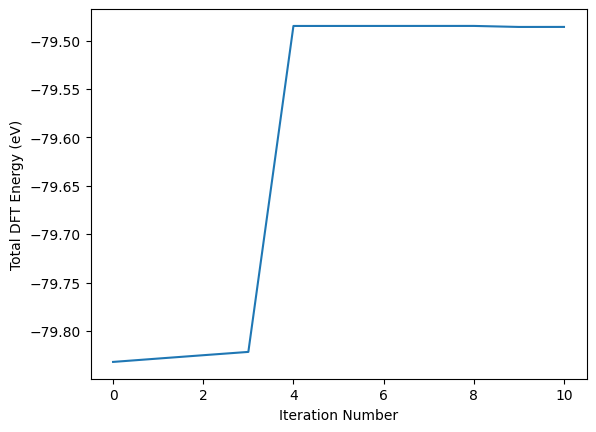

In [9]:
nIter, neList, Elist = negf2.SCF(1e-3, 0.01, checkpoint=False)
# Plot convergence of DFT Energy
plt.plot(nIter, Elist)
plt.xlabel('Iteration Number')
plt.ylabel('Total DFT Energy (eV)')

This method use complex contour integration of the retarded Green's function to calculate the density matrix, based on the following equation.

$$
\hat{\rho} =  -\frac{1}{\pi}\mathbb{Im}\left[\int_{-\infty}^{E_F} \hat{G}^R(E) dE \right]      
$$

Note that this assumes that temperature is zero, as used in the energy-independent case.

## Comparison of Approaches

We can now compare the generated density matrices side by side:

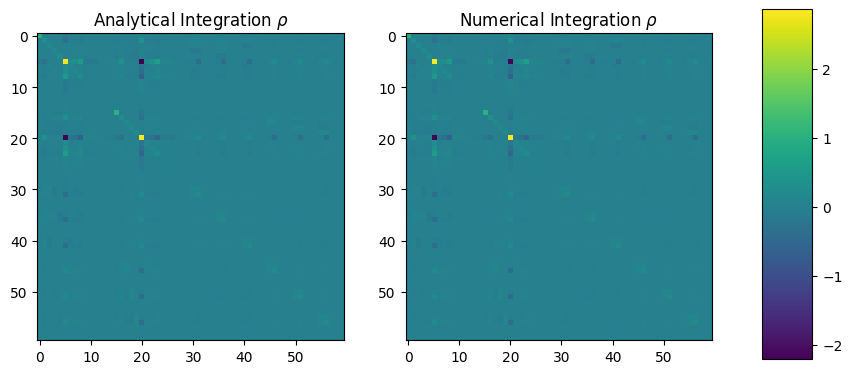

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
im = ax1.imshow(negf.P.real)
ax1.set_title(r'Analytical Integration $\rho$')
im2 = ax2.imshow(negf2.P.real)
ax2.set_title(r'Numerical Integration $\rho$')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax)

As a second check, we can calculate the density of states using each method. First, we need to import the `transport` package and generate the energy grid, then calculate DOS for each object:

Text(0, 0.5, 'Density of States')

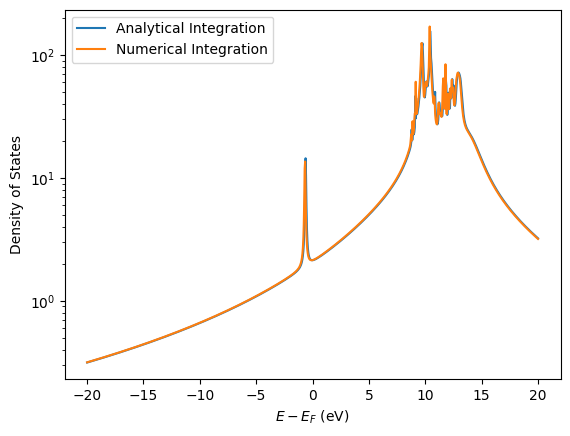

In [11]:
from gauNEGF.transport import *

Elist = np.linspace(-20, 20, 1000)
DOS1, _ = calculate_dos(negf.F, negf.S, SigmaCalculator(negf.sigma1, negf.sigma2), Elist+negf.fermi)
DOS2, _ = calculate_dos(negf2.F, negf2.S, SigmaCalculator(negf2.g), Elist+negf2.fermi)
plt.semilogy(Elist, DOS1, Elist, DOS2)
plt.legend(('Analytical Integration', 'Numerical Integration'))
plt.xlabel(r'$E-E_F$ (eV)')
plt.ylabel('Density of States')

## IV Characteristic Comparison

We can now use NEGF to sweep the voltage and calculate current across the molecule. This requires using the NEGF-DFT solver at each voltage point to calculate the transmission and then integrating to get the current. For $T=0 K$ the fermi function becomes a step function and the Landauer formula simplifies to:

$$
I(V)= \frac{q^2}{h}\int_{\mu - \frac{qV}{2}}^{\mu + \frac{qV}{2}} T(E, V) dE
$$

which is calculated after convergence using the `calculate_current()` functions from `transport.py` (_NOTE: This calculation can take some time to run_):

In [12]:
import io
import contextlib

# Voltage from 0 to 0.5 to -0.5 to 0
Vlist = list(np.arange(0.1, 0.5, 0.1))
Vlist += list(np.arange(0.5, -0.5, -0.1))
Vlist +=  list(np.arange(-0.5, 0.1, 0.1))
Ilist = []
IlistE =[]
for V in Vlist:
    print(f'SETTING VOLTAGE: {V} V')
    with contextlib.redirect_stdout(io.StringIO()) as f:
        negf.setVoltage(V, fermi=negf.fermi)
        negf.SCF(1e-3, 0.02)
        negf2.setVoltage(V, fermi=negf.fermi)
        negf2.SCF(1e-3, 0.02)
        I = current(negf.F, negf.S, negf.sigma1, negf.sigma2, negf.fermi, V)
        I2 = currentE(negf2.F, negf2.S, negf2.g, negf2.fermi, V)
    Ilist.append(I)
    IlistE.append(I2)
    print(f'CALCULATED CURRENT Energy independent -  {I} A, Energy dependent - {I2} A')
print('IV COMPLETE!')


SETTING VOLTAGE: 0.1 V
CALCULATED CURRENT Energy independent -  1.1365075024657524e-06 A, Energy dependent - 1.1365533413906508e-06 A
SETTING VOLTAGE: 0.2 V
CALCULATED CURRENT Energy independent -  2.262034787007232e-06 A, Energy dependent - 2.2620833909996742e-06 A
SETTING VOLTAGE: 0.30000000000000004 V
CALCULATED CURRENT Energy independent -  3.411274618570013e-06 A, Energy dependent - 3.4112896194163353e-06 A
SETTING VOLTAGE: 0.4 V
CALCULATED CURRENT Energy independent -  4.537991892825389e-06 A, Energy dependent - 4.537998939880989e-06 A
SETTING VOLTAGE: 0.5 V
CALCULATED CURRENT Energy independent -  5.677074549156394e-06 A, Energy dependent - 5.677092419417683e-06 A
SETTING VOLTAGE: 0.4 V
CALCULATED CURRENT Energy independent -  4.538002617144368e-06 A, Energy dependent - 4.537979157891349e-06 A
SETTING VOLTAGE: 0.30000000000000004 V
CALCULATED CURRENT Energy independent -  3.4113142251517727e-06 A, Energy dependent - 3.411284036394324e-06 A
SETTING VOLTAGE: 0.20000000000000007 V


Now, as a final confirmation, we can plot these and make sure they match up:

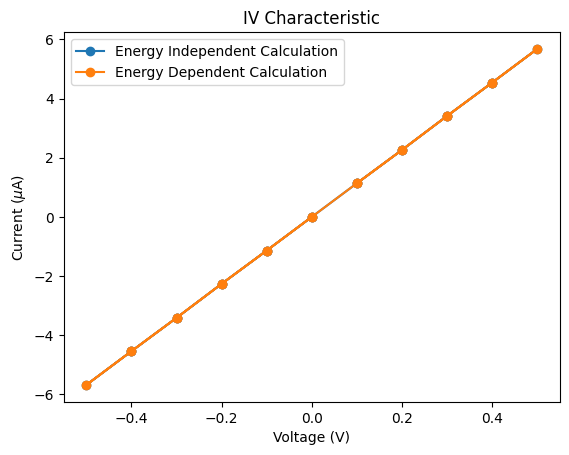

In [13]:
plt.plot(Vlist, [I*1e6 for I in Ilist], '-o')
plt.plot(Vlist, [I*1e6 for I in IlistE], '-o')
plt.xlabel('Voltage (V)')
plt.ylabel(r'Current ($\mu$A)')
plt.title('IV Characteristic')
plt.legend(('Energy Independent Calculation', 'Energy Dependent Calculation'))